Dataset loaded successfully with shape: (578923, 45)
Number of classes: 8



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 44)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │          88,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 1, 128)              │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ [(None, 128), (None, 1,     │          16,512 │
│                                      │ 128)]                       │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,944 (452.91 KB)

 Trainable params: 115,944 (452.91 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/50
10855/10855 ━━━━━━━━━━━━━━━━━━━━ 108s 9ms/step - accuracy: 0.9470 - loss: 0.6403 - val_accuracy: 0.9695 - val_loss: 0.5478
Epoch 2/50
10855/10855 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.9678 - loss: 0.5617 - val_accuracy: 0.9717 - val_loss: 0.5427
Epoch 3/50
10855/10855 ━━━━━━━━━━━━━━━━━━━━ 104s 10ms/step - accuracy: 0.9712 - loss: 0.5505 - val_accuracy: 0.9745 - val_loss: 0.5332
Epoch 4/50
10855/10855 ━━━━━━━━━━━━━━━━━━━━ 102s 9ms/step - accuracy: 0.9738 - loss: 0.5423 - val_accuracy: 0.9763 - val_loss: 0.5269
Epoch 5/50
10855/10855 ━━━━━━━━━━━━━━━━━━━━ 146s 10ms/step - accuracy: 0.9755 - loss: 0.5374 - val_accuracy: 0.9775 - val_loss: 0.5247
Epoch 6/50
10855/10855 ━━━━━━━━━━━━━━━━━━━━ 104s 10ms/step - accuracy: 0.9764 - loss: 0.5318 - val_accuracy: 0.9758 - val_loss: 0.5280
Epoch 7/50
10855/10855 ━━━━━━━━━━━━━━━━━━━━ 108s 10ms/step - accuracy: 0.9765 - loss: 0.5287 - val_accuracy: 0.9781 - val_l

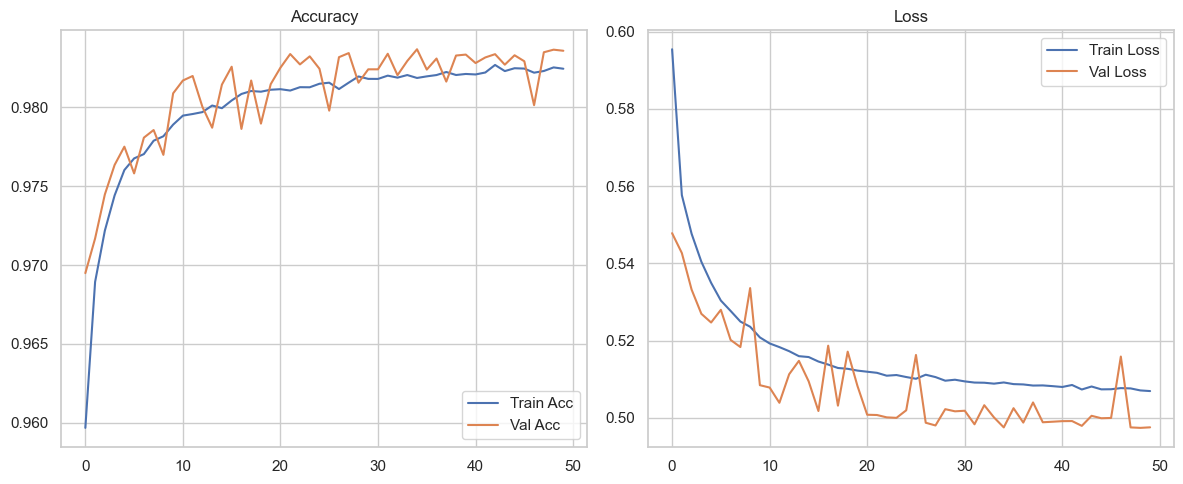

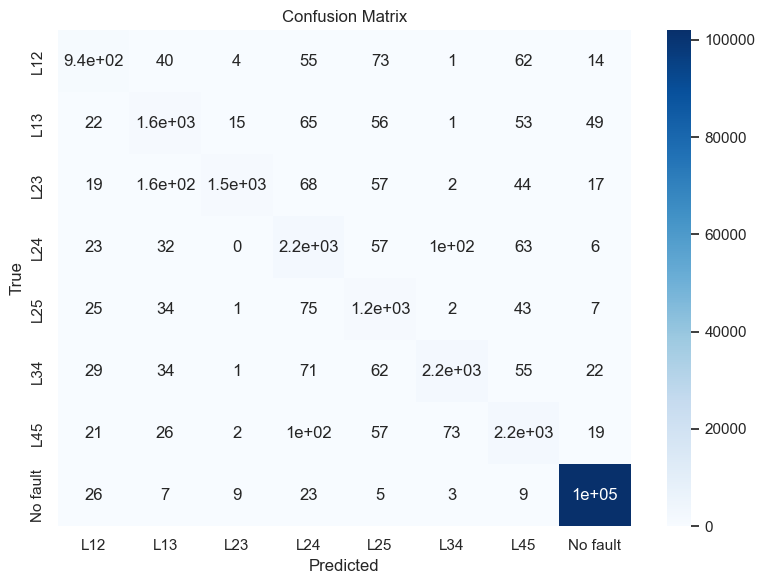

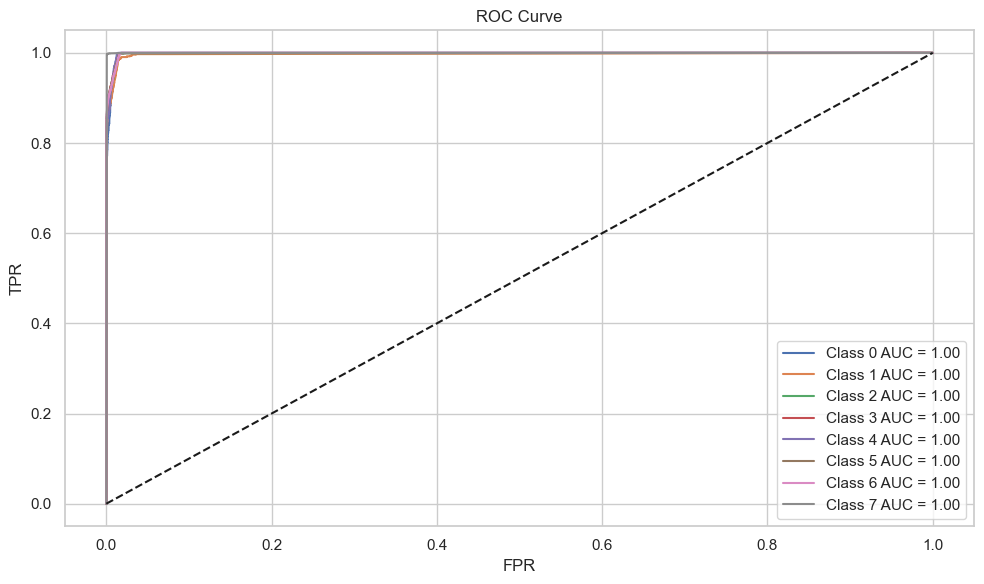

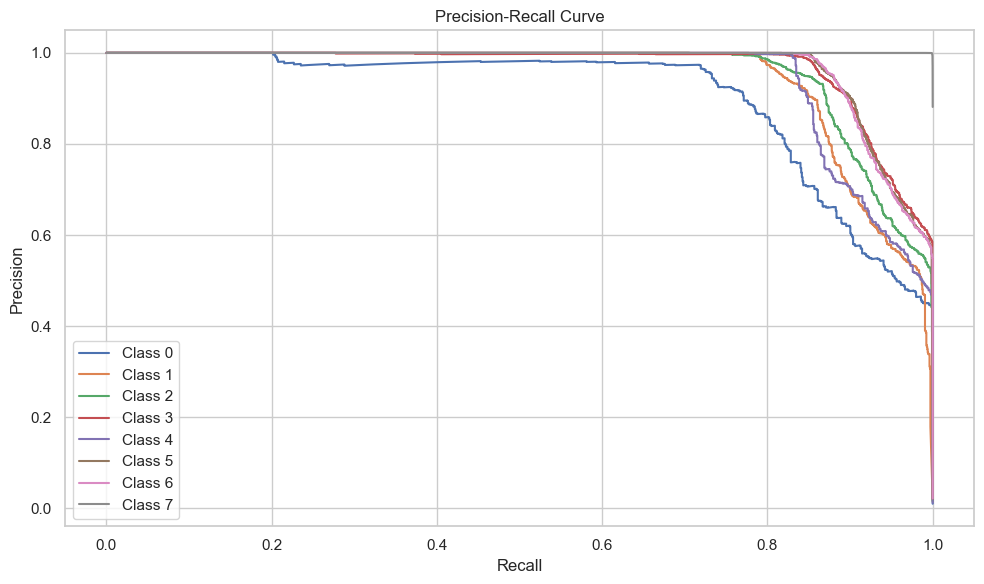

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


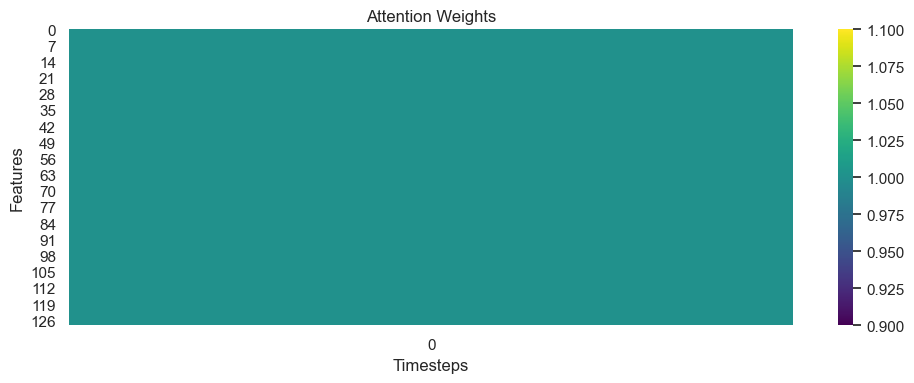

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, LayerNormalization, Flatten, Add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
import os

plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

FILE_PATH = r"C:\\Users\\devin\\Desktop\\tlfd.xlsx"
np.random.seed(42)
tf.random.set_seed(42)


# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


def load_data(file_path, test_size=0.2, val_size=0.2):
    data = pd.read_excel(file_path)
    print(f"Dataset loaded successfully with shape: {data.shape}")

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].values

    le = LabelEncoder()
    y = le.fit_transform(y)
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")
    y_cat = to_categorical(y, num_classes=num_classes)

    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=(test_size + val_size), random_state=42)
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train, X_val, X_test, y_train, y_val, y_test, num_classes, le


def create_attention_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(128, return_sequences=True)(inputs)
    lstm_out = LayerNormalization()(lstm_out)
    attention_out, att_weights = AttentionLayer()(lstm_out)
    dense1 = Dense(64, activation='relu')(attention_out)
    dropout1 = Dropout(0.3)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    outputs = Dense(num_classes, activation='softmax')(dropout2)

    model = Model(inputs=inputs, outputs=outputs)
    model.att_model = Model(inputs=inputs, outputs=att_weights)
    return model


def apply_label_smoothing(y, factor=0.1):
    return y * (1 - factor) + (factor / y.shape[1])


def train_model(model, X_train, y_train, X_val, y_val):
    y_train_smooth = apply_label_smoothing(y_train)
    y_val_smooth = apply_label_smoothing(y_val)

    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train_smooth, validation_data=(X_val, y_val_smooth),
                        epochs=50, batch_size=32, callbacks=[checkpoint, early_stop])
    return history


def evaluate_model(model, X_test, y_test, le):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print("Accuracy:", accuracy_score(y_true, y_pred) * 100)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))
    return y_pred_prob, y_true, y_pred, confusion_matrix(y_true, y_pred)


def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.savefig("training_history.png")
    plt.show()


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()


def plot_roc_curve(y_true, y_prob, n_classes):
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    plt.show()


def plot_precision_recall(y_true, y_prob, n_classes):
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
        plt.plot(recall, precision, label=f"Class {i}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig("precision_recall.png")
    plt.show()


def plot_attention_weights(model, X_sample):
    attention_weights = model.att_model.predict(X_sample[np.newaxis, ...])[0]
    plt.figure(figsize=(10, 4))
    sns.heatmap(attention_weights.T, cmap='viridis', cbar=True)
    plt.title("Attention Weights")
    plt.xlabel("Timesteps")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.savefig("attention_weights.png")
    plt.show()


def main():
    X_train, X_val, X_test, y_train, y_val, y_test, num_classes, le = load_data(FILE_PATH)
    model = create_attention_lstm_model((X_train.shape[1], X_train.shape[2]), num_classes)
    model.summary()
    plot_model(model, to_file="model_architecture.png", show_shapes=True)

    history = train_model(model, X_train, y_train, X_val, y_val)

    y_prob, y_true, y_pred, cm = evaluate_model(model, X_test, y_test, le)
    plot_training_history(history)
    plot_confusion_matrix(cm, le.classes_)
    plot_roc_curve(y_test, y_prob, num_classes)
    plot_precision_recall(y_test, y_prob, num_classes)

    # Visualize attention weights for one sample
    plot_attention_weights(model, X_test[0])


if __name__ == "__main__":
    main()


Dataset loaded successfully with shape: (578923, 45)
Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 44)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │          88,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 1, 128)              │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ [(None, 128), (None, 1,     │          16,512 │
│                                      │ 128)]                       │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 347,834 (1.33 MB)

 Trainable params: 115,944 (452.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 231,890 (905.82 KB)

18092/18092 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step
Accuracy: 98.38%

Classification Report:
              precision    recall  f1-score   support

         L12       0.81      0.80      0.81      5576
         L13       0.87      0.88      0.88      9398
         L23       0.99      0.81      0.89      9402
         L24       0.74      0.91      0.82     12555
         L25       0.86      0.86      0.86      7128
         L34       0.92      0.90      0.91     12555
         L45       0.97      0.87      0.92     12555
    No fault       1.00      1.00      1.00    509754

    accuracy                           0.98    578923
   macro avg       0.90      0.88      0.88    578923
weighted avg       0.99      0.98      0.98    578923



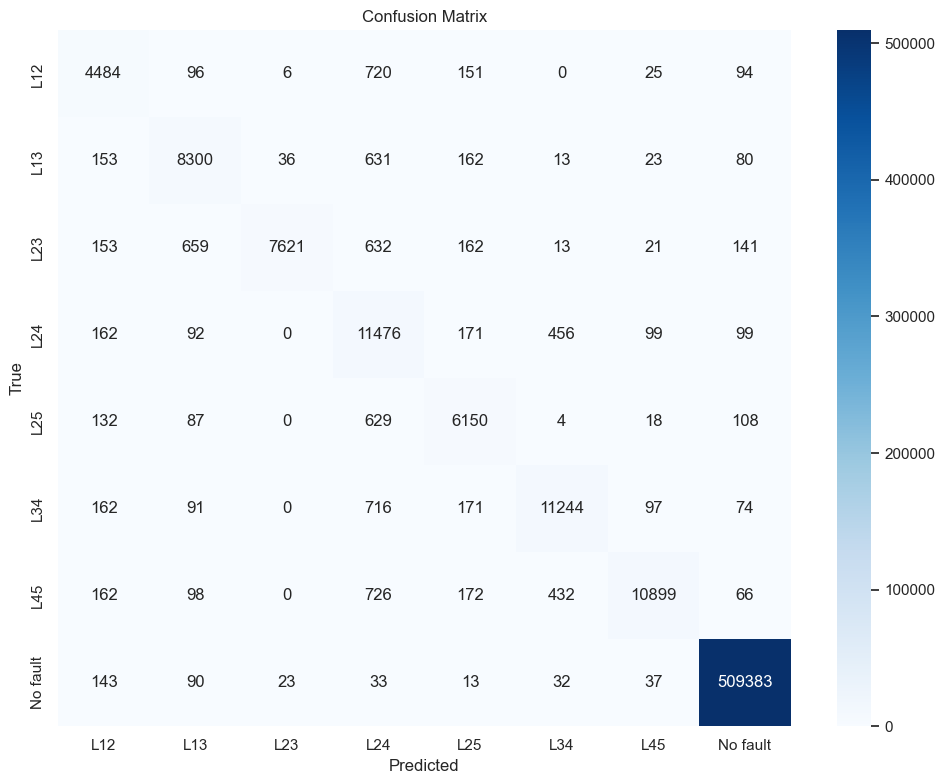

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


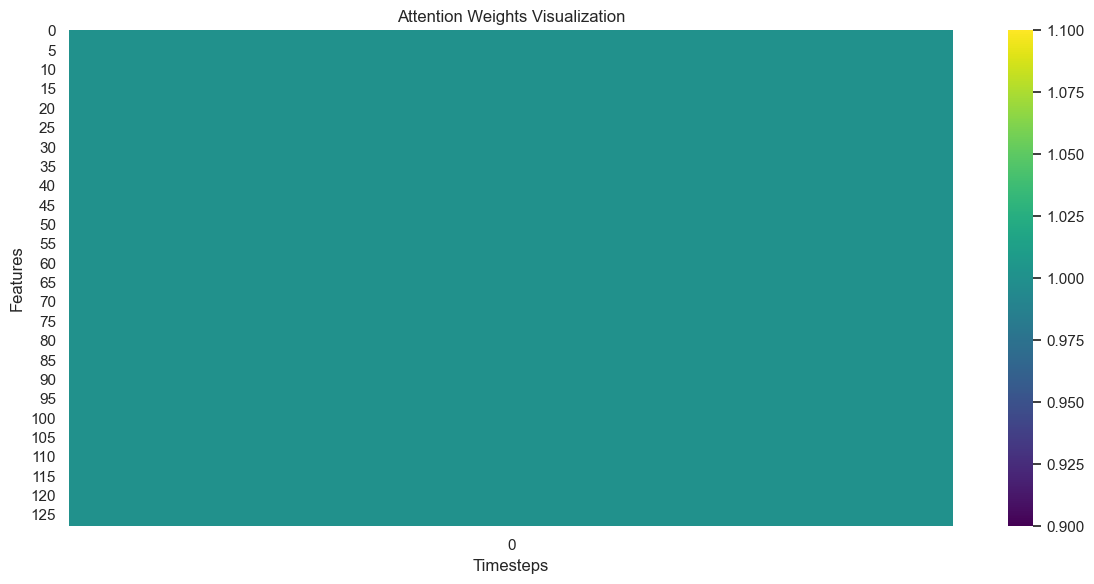

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the AttentionLayer class since it's a custom layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# File path for your data
FILE_PATH = r"C:\\Users\\devin\\Desktop\\tlfd.xlsx"

# Load and prepare the data
def load_and_prepare_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Dataset loaded successfully with shape: {data.shape}")

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].values

    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Convert X to numeric values and handle NaNs
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Reshape for LSTM input
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    return X_reshaped, y, le

# Load the saved model with custom layer
def load_saved_model(model_path='best_model.keras'):
    # You need to specify custom objects for the model to load correctly
    custom_objects = {'AttentionLayer': AttentionLayer}
    model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully!")
    return model

# Evaluate the model
def evaluate_loaded_model(model, X, y_true, le):
    # Get predictions
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100
    print(f"Accuracy: {accuracy:.2f}%")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    
    # Create and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('evaluation_confusion_matrix.png')
    plt.show()
    
    return y_pred_prob, y_pred, cm

# Visualize attention weights for sample data
def visualize_attention(model, X_sample):
    # Create a new model that outputs the attention weights
    attention_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.get_layer('attention_layer').output[1]
    )
    
    # Get attention weights for the sample
    attention_weights = attention_model.predict(X_sample[np.newaxis, ...])[0]
    
    # Plot attention weights
    plt.figure(figsize=(12, 6))
    sns.heatmap(attention_weights.T, cmap='viridis')
    plt.title('Attention Weights Visualization')
    plt.xlabel('Timesteps')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig('attention_weights_evaluation.png')
    plt.show()

# Main function to execute evaluation
def main():
    # Load and prepare the data
    X, y, le = load_and_prepare_data(FILE_PATH)
    
    # Load the saved model
    model = load_saved_model()
    
    # Show model summary
    model.summary()
    
    # Evaluate the model
    y_prob, y_pred, cm = evaluate_loaded_model(model, X, y, le)
    
    # Visualize attention for the first sample
    try:
        visualize_attention(model, X[0])
    except Exception as e:
        print(f"Error visualizing attention: {e}")
        print("Try using the att_model attribute if defined in your original model")
        try:
            attention_weights = model.att_model.predict(X[0:1])[0]
            plt.figure(figsize=(10, 4))
            sns.heatmap(attention_weights.T, cmap='viridis', cbar=True)
            plt.title("Attention Weights")
            plt.xlabel("Timesteps")
            plt.ylabel("Features")
            plt.tight_layout()
            plt.savefig("attention_weights_evaluation.png")
            plt.show()
        except Exception as e2:
            print(f"Alternative method also failed: {e2}")

# Execute the code
if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Set global font size for all plots
plt.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
sns.set_theme(style="whitegrid", font_scale=1.2)

# Define the AttentionLayer class since it's a custom layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# File path for your data
FILE_PATH = r"C:\\Users\\devin\\Desktop\\tlfd.xlsx"

# Load and prepare the data
def load_and_prepare_data(file_path, test_size=0.2):
    data = pd.read_excel(file_path)
    print(f"Dataset loaded successfully with shape: {data.shape}")

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].values

    le = LabelEncoder()
    y = le.fit_transform(y)
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")
    y_cat = to_categorical(y, num_classes=num_classes)
    
    # Convert X to numeric values and handle NaNs
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Reshape for LSTM input
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    return X_reshaped, y, y_cat, le, num_classes

# Load the saved model with custom layer
def load_saved_model(model_path='best_model.keras'):
    # You need to specify custom objects for the model to load correctly
    custom_objects = {'AttentionLayer': AttentionLayer}
    model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully!")
    return model

# Evaluate the model
def evaluate_loaded_model(model, X, y_true, y_cat, le, num_classes):
    # Get predictions
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100
    print(f"Accuracy: {accuracy:.2f}%")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    
    # Create and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('True', fontsize=16)
    plt.title('Confusion Matrix', fontsize=18)
    plt.tight_layout()
    plt.savefig('evaluation_confusion_matrix.png', dpi=300)
    plt.show()
    
    # Plot ROC Curve
    plot_roc_curve(y_cat, y_pred_prob, num_classes, le.classes_)
    
    # Plot Precision-Recall Curve
    plot_precision_recall(y_cat, y_pred_prob, num_classes, le.classes_)
    
    return y_pred_prob, y_pred, cm

# Plot ROC curve
def plot_roc_curve(y_true, y_prob, n_classes, class_names):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})", linewidth=2, color=colors[i])
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve for All Classes', fontsize=18)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("evaluation_roc_curve.png", dpi=300)
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall(y_true, y_prob, n_classes, class_names):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
    
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]}", linewidth=2, color=colors[i])
    
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Precision-Recall Curve', fontsize=18)
    plt.legend(loc="best", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("evaluation_precision_recall.png", dpi=300)
    plt.show()

# Visualize attention weights for sample data
def visualize_attention(model, X_sample):
    try:
        # First attempt: Create a new model that outputs the attention weights
        attention_model = tf.keras.Model(
            inputs=model.input,
            outputs=model.get_layer('attention_layer').output[1]
        )
        
        # Get attention weights for the sample
        attention_weights = attention_model.predict(X_sample[np.newaxis, ...])[0]
    except Exception as e:
        print(f"Error in first approach: {e}")
        # Second attempt: Use the att_model attribute if defined
        try:
            attention_weights = model.att_model.predict(X_sample[np.newaxis, ...])[0]
        except Exception as e2:
            print(f"Error in second approach: {e2}")
            print("Could not visualize attention weights")
            return
    
    # Plot attention weights
    plt.figure(figsize=(14, 8))
    sns.heatmap(attention_weights.T, cmap='viridis', cbar=True)
    plt.title('Attention Weights Visualization', fontsize=18)
    plt.xlabel('Timesteps', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    plt.tight_layout()
    plt.savefig('attention_weights_evaluation.png', dpi=300)
    plt.show()

# Simulate training history plot (from saved history if available)
def try_plot_training_history():
    try:
        # Try to load history from a saved file if you have it
        history = np.load('training_history.npz', allow_pickle=True)
        history_dict = history['history'].item() if 'history' in history.files else None
        
        if history_dict:
            plot_training_history(history_dict)
        else:
            print("Could not load training history.")
    except Exception as e:
        print(f"Error loading training history: {e}")
        print("If you have the training history saved in another format, please modify this function.")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(16, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], 'b-', linewidth=2, label='Training')
    plt.plot(history['val_accuracy'], 'r-', linewidth=2, label='Validation')
    plt.title('Model Accuracy', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], 'b-', linewidth=2, label='Training')
    plt.plot(history['val_loss'], 'r-', linewidth=2, label='Validation')
    plt.title('Model Loss', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history_evaluation.png', dpi=300)
    plt.show()

# Main function to execute evaluation
def main():
    # Load and prepare the data
    X, y, y_cat, le, num_classes = load_and_prepare_data(FILE_PATH)
    
    # Load the saved model
    model = load_saved_model()
    
    # Show model summary
    model.summary()
    
    # Try to plot training history if available
    try_plot_training_history()
    
    # Evaluate the model
    y_prob, y_pred, cm = evaluate_loaded_model(model, X, y, y_cat, le, num_classes)
    
    # Visualize attention for the first sample
    visualize_attention(model, X[0])
    
    print("\nEvaluation complete! All plots have been saved.")

# Execute the code
if __name__ == "__main__":
    main()

Dataset loaded successfully with shape: (578923, 45)
Number of classes: 8
Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 44)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │          88,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 1, 128)              │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ [(None, 128), (None, 1,     │          16,512 │
│                                      │ 128)]                       │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 347,834 (1.33 MB)

 Trainable params: 115,944 (452.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 231,890 (905.82 KB)

Error loading training history: [Errno 2] No such file or directory: 'training_history.npz'
If you have the training history saved in another format, please modify this function.
18092/18092 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step
Accuracy: 98.38%

Classification Report:
              precision    recall  f1-score   support

         L12       0.81      0.80      0.81      5576
         L13       0.87      0.88      0.88      9398
         L23       0.99      0.81      0.89      9402
         L24       0.74      0.91      0.82     12555
         L25       0.86      0.86      0.86      7128
         L34       0.92      0.90      0.91     12555
         L45       0.97      0.87      0.92     12555
    No fault       1.00      1.00      1.00    509754

    accuracy                           0.98    578923
   macro avg       0.90      0.88      0.88    578923
weighted avg       0.99      0.98      0.98    578923



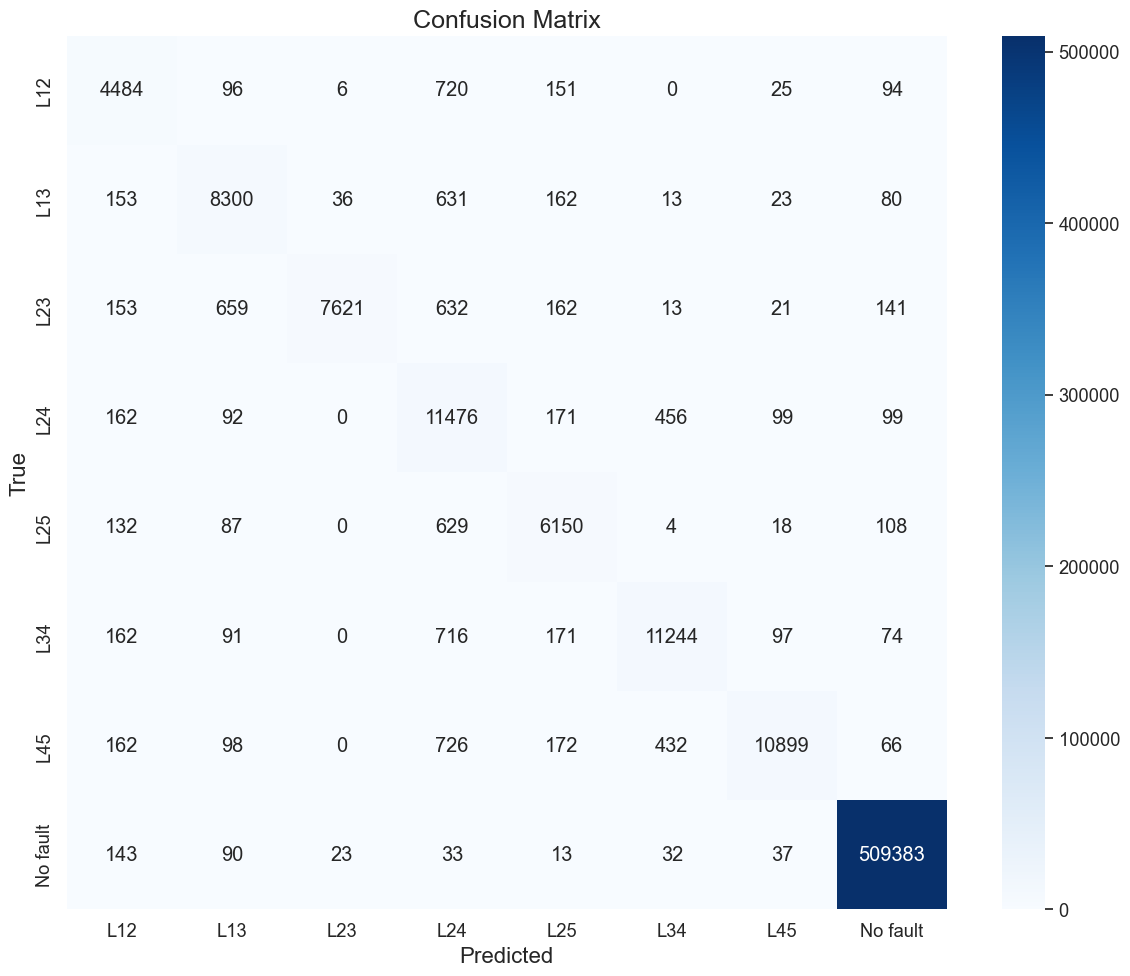

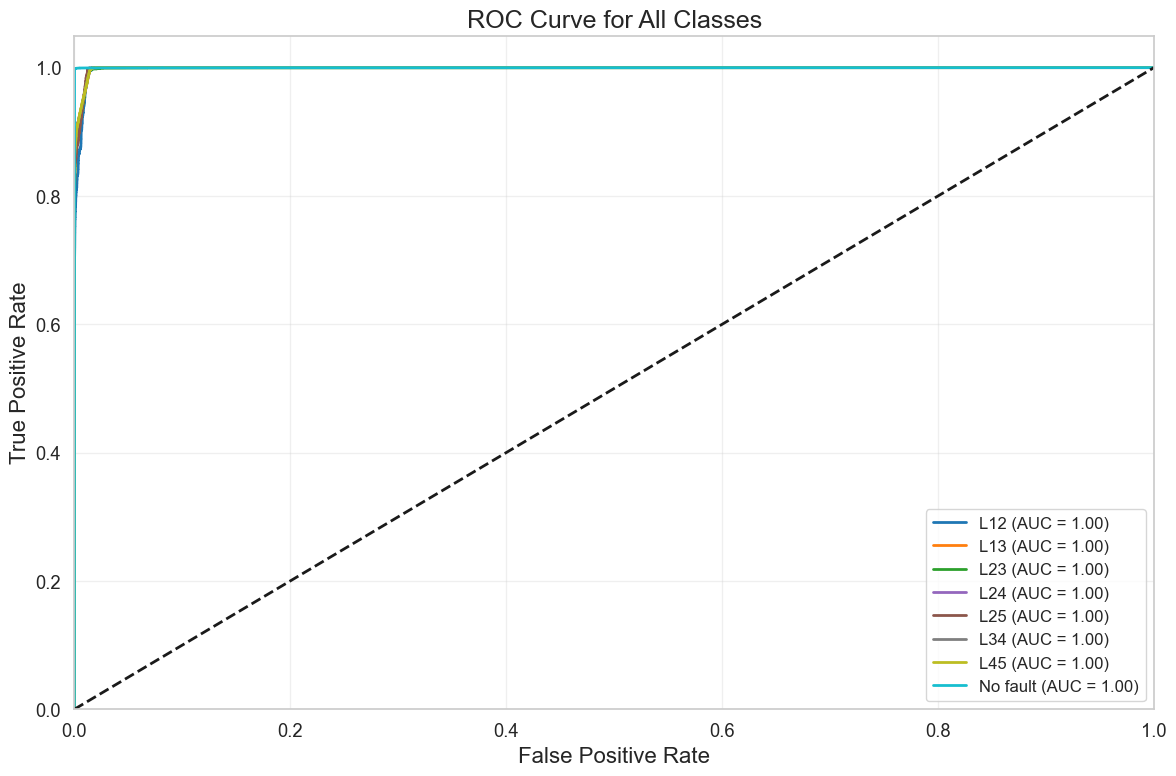

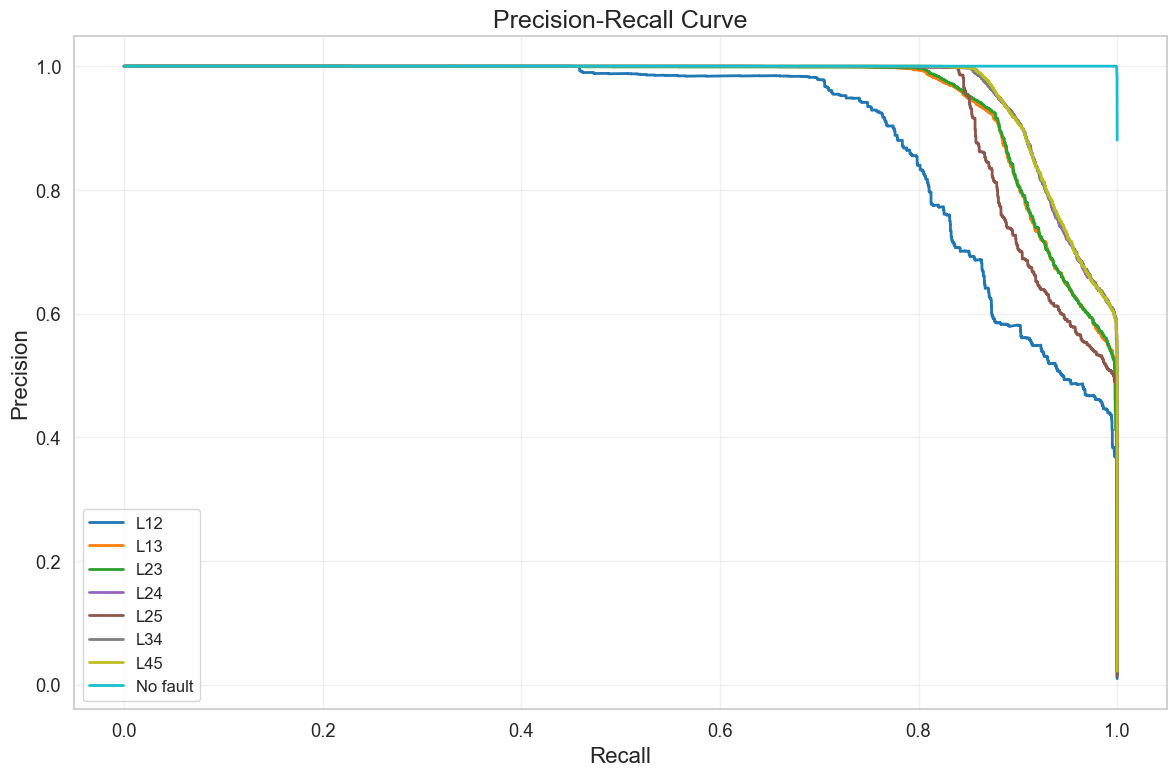

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


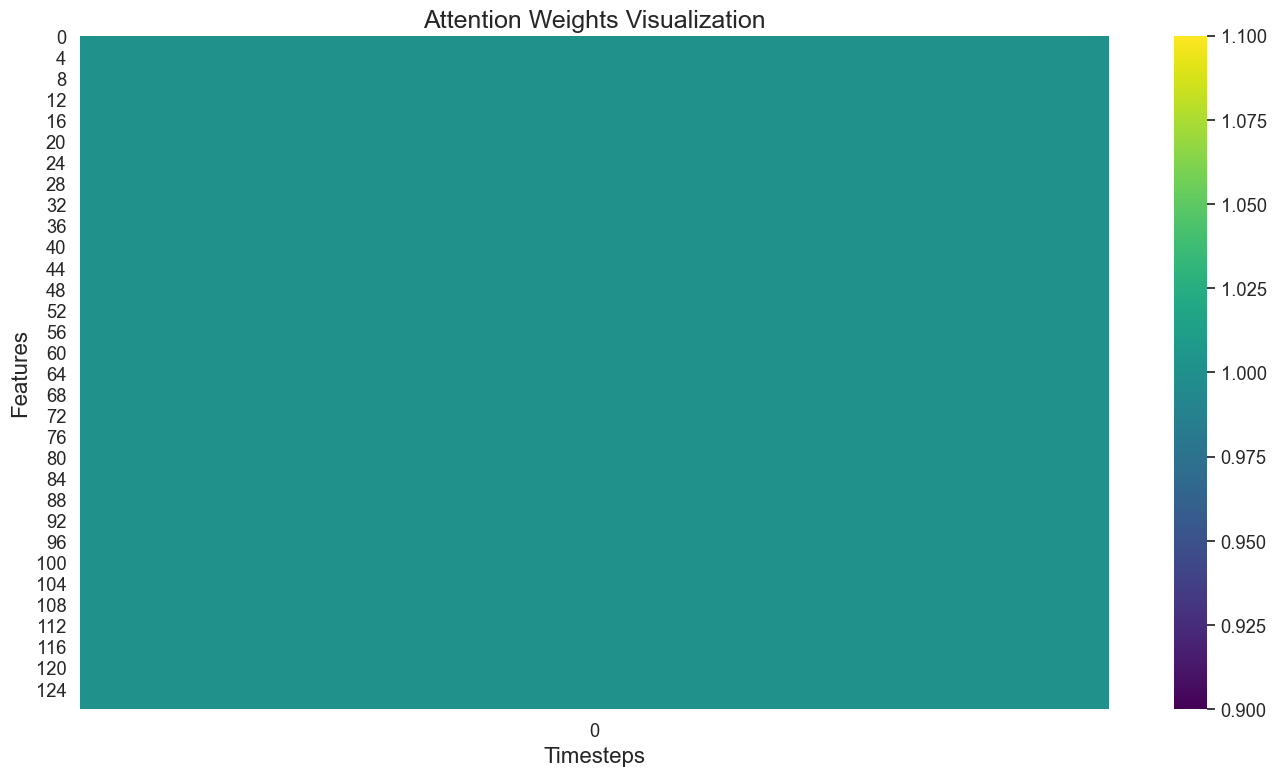


Starting SHAP Analysis for Explainable AI...

==== Starting SHAP Analysis ====
Analyzing model with 100 background samples...
Creating KernelExplainer...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Computing SHAP values for 10 samples (this may take some time)...


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
SHAP values computed successfully!
Error creating summary plot for class 0: The shape of the shap_values matrix does not match the shape of the provided data matrix.
Error creatin

C:\Users\devin\AppData\Local\Temp\ipykernel_24984\2284473196.py:373: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 3))


Error creating dependence plot for class 3: 'shap_values' and 'features' values must have the same number of rows!
Error creating dependence plot for class 4: 'shap_values' and 'features' values must have the same number of rows!
Error creating dependence plot for class 5: 'shap_values' and 'features' values must have the same number of rows!
Error creating dependence plot for class 6: 'shap_values' and 'features' values must have the same number of rows!
Error creating dependence plot for class 7: 'shap_values' and 'features' values must have the same number of rows!


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

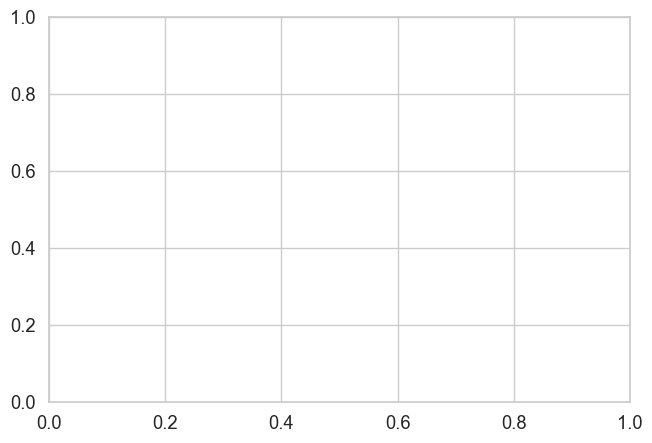

<Figure size 1000x700 with 0 Axes>

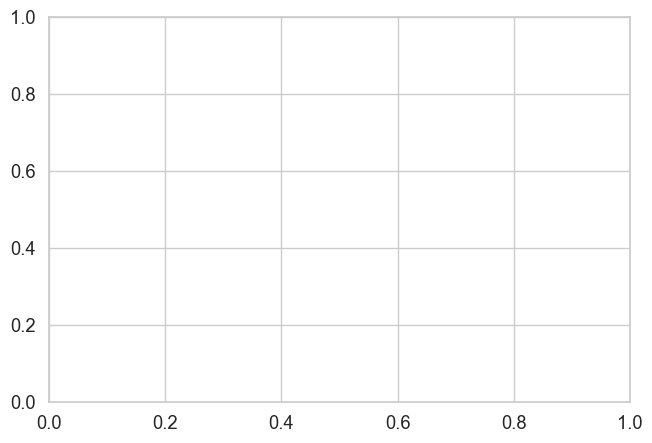

<Figure size 1000x700 with 0 Axes>

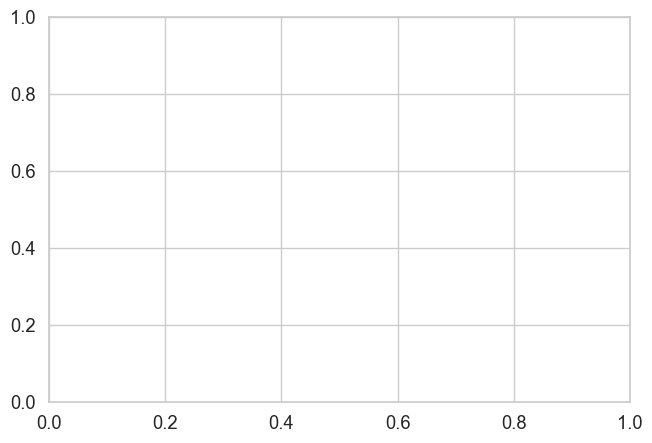

<Figure size 1000x700 with 0 Axes>

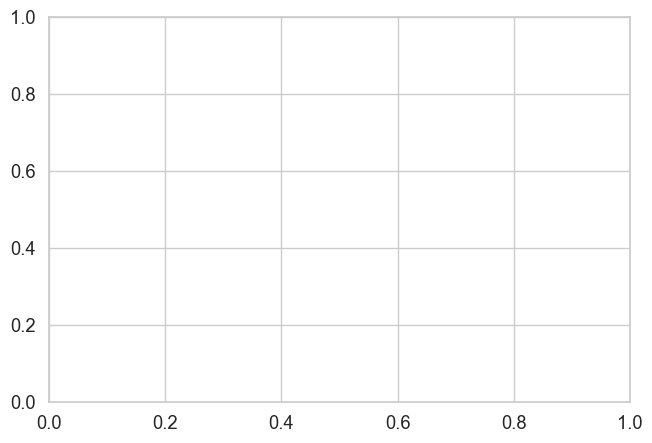

<Figure size 1000x700 with 0 Axes>

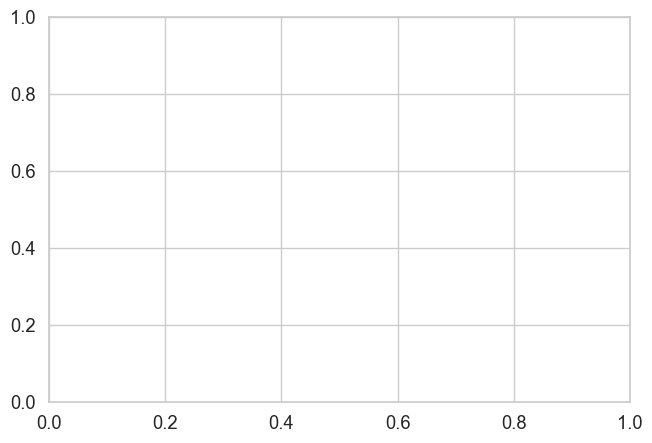

<Figure size 1000x700 with 0 Axes>

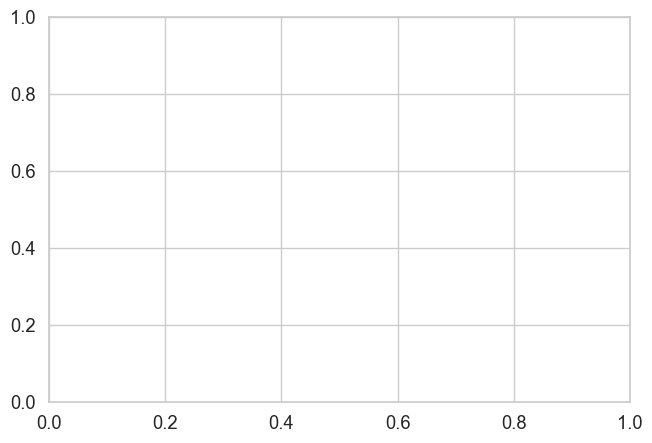

<Figure size 1000x700 with 0 Axes>

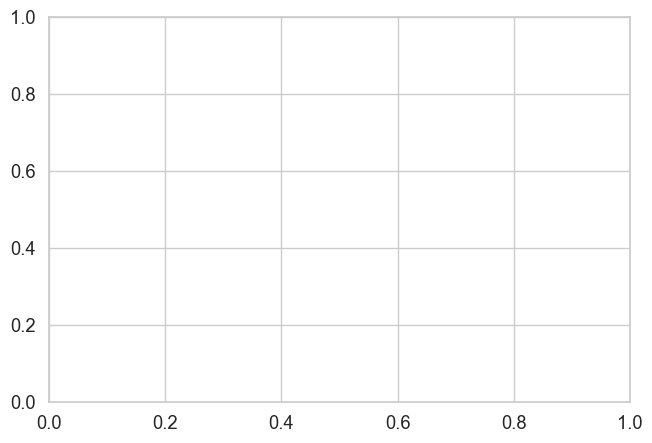

<Figure size 1000x700 with 0 Axes>

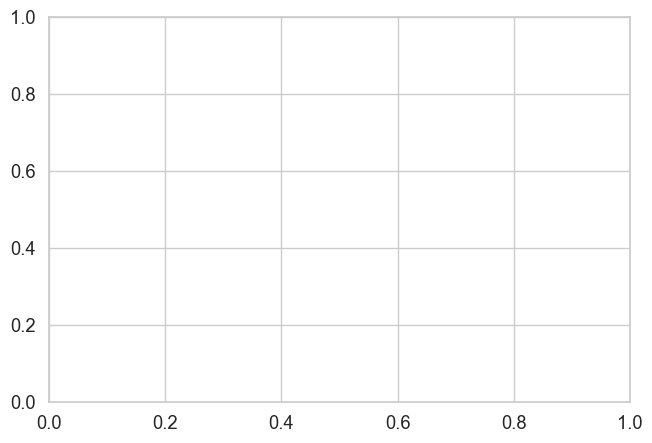

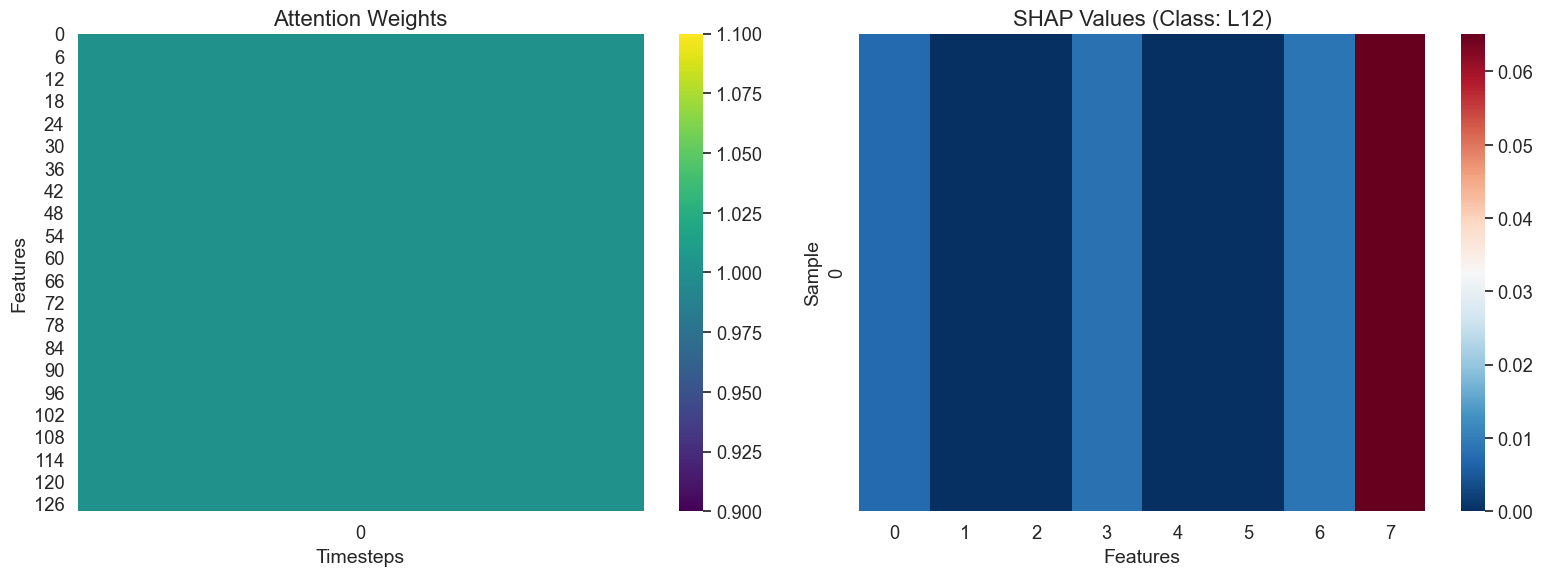


==== SHAP Interpretation ====

Top 5 influential features for class 'L12':
1. Ia23: Importance = 0.0171, generally increases prediction
2. Ia13: Importance = 0.0061, generally decreases prediction
3. IaL12: Importance = 0.0044, generally decreases prediction
4. IbL12: Importance = 0.0031, generally decreases prediction
5. IcL12: Importance = 0.0027, generally decreases prediction

Top 5 influential features for class 'L13':
1. Ia23: Importance = 0.0173, generally increases prediction
2. Ia13: Importance = 0.0064, generally decreases prediction
3. IaL12: Importance = 0.0040, generally decreases prediction
4. IbL12: Importance = 0.0034, generally decreases prediction
5. Ib13: Importance = 0.0027, generally decreases prediction

Top 5 influential features for class 'L23':
1. Ia23: Importance = 0.0167, generally increases prediction
2. Ia13: Importance = 0.0070, generally decreases prediction
3. IaL12: Importance = 0.0043, generally decreases prediction
4. Ib13: Importance = 0.0031, gener

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import shap  # Import SHAP library

# Set global font size for all plots
plt.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
sns.set_theme(style="whitegrid", font_scale=1.2)

# Define the AttentionLayer class since it's a custom layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# File path for your data
FILE_PATH = r"C:\\Users\\devin\\Desktop\\tlfd.xlsx"

# Load and prepare the data
def load_and_prepare_data(file_path, test_size=0.2):
    data = pd.read_excel(file_path)
    print(f"Dataset loaded successfully with shape: {data.shape}")

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].values

    # Store feature names for SHAP analysis
    feature_names = X.columns.tolist()

    le = LabelEncoder()
    y = le.fit_transform(y)
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")
    y_cat = to_categorical(y, num_classes=num_classes)
    
    # Convert X to numeric values and handle NaNs
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store original data for SHAP analysis
    X_original = X_scaled.copy()
    
    # Reshape for LSTM input
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    return X_reshaped, X_original, y, y_cat, le, feature_names, num_classes

# Load the saved model with custom layer
def load_saved_model(model_path='best_model.keras'):
    # You need to specify custom objects for the model to load correctly
    custom_objects = {'AttentionLayer': AttentionLayer}
    model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully!")
    return model

# Evaluate the model
def evaluate_loaded_model(model, X, y_true, y_cat, le, num_classes):
    # Get predictions
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100
    print(f"Accuracy: {accuracy:.2f}%")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    
    # Create and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('True', fontsize=16)
    plt.title('Confusion Matrix', fontsize=18)
    plt.tight_layout()
    plt.savefig('evaluation_confusion_matrix.png', dpi=300)
    plt.show()
    
    # Plot ROC Curve
    plot_roc_curve(y_cat, y_pred_prob, num_classes, le.classes_)
    
    # Plot Precision-Recall Curve
    plot_precision_recall(y_cat, y_pred_prob, num_classes, le.classes_)
    
    return y_pred_prob, y_pred, cm

# Plot ROC curve
def plot_roc_curve(y_true, y_prob, n_classes, class_names):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})", linewidth=2, color=colors[i])
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve for All Classes', fontsize=18)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("evaluation_roc_curve.png", dpi=300)
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall(y_true, y_prob, n_classes, class_names):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
    
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]}", linewidth=2, color=colors[i])
    
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Precision-Recall Curve', fontsize=18)
    plt.legend(loc="best", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("evaluation_precision_recall.png", dpi=300)
    plt.show()

# Visualize attention weights for sample data
def visualize_attention(model, X_sample):
    try:
        # First attempt: Create a new model that outputs the attention weights
        attention_model = tf.keras.Model(
            inputs=model.input,
            outputs=model.get_layer('attention_layer').output[1]
        )
        
        # Get attention weights for the sample
        attention_weights = attention_model.predict(X_sample[np.newaxis, ...])[0]
    except Exception as e:
        print(f"Error in first approach: {e}")
        # Second attempt: Use the att_model attribute if defined
        try:
            attention_weights = model.att_model.predict(X_sample[np.newaxis, ...])[0]
        except Exception as e2:
            print(f"Error in second approach: {e2}")
            print("Could not visualize attention weights")
            return None
    
    # Plot attention weights
    plt.figure(figsize=(14, 8))
    sns.heatmap(attention_weights.T, cmap='viridis', cbar=True)
    plt.title('Attention Weights Visualization', fontsize=18)
    plt.xlabel('Timesteps', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    plt.tight_layout()
    plt.savefig('attention_weights_evaluation.png', dpi=300)
    plt.show()
    
    return attention_weights

# Simulate training history plot (from saved history if available)
def try_plot_training_history():
    try:
        # Try to load history from a saved file if you have it
        history = np.load('training_history.npz', allow_pickle=True)
        history_dict = history['history'].item() if 'history' in history.files else None
        
        if history_dict:
            plot_training_history(history_dict)
        else:
            print("Could not load training history.")
    except Exception as e:
        print(f"Error loading training history: {e}")
        print("If you have the training history saved in another format, please modify this function.")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(16, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], 'b-', linewidth=2, label='Training')
    plt.plot(history['val_accuracy'], 'r-', linewidth=2, label='Validation')
    plt.title('Model Accuracy', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], 'b-', linewidth=2, label='Training')
    plt.plot(history['val_loss'], 'r-', linewidth=2, label='Validation')
    plt.title('Model Loss', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history_evaluation.png', dpi=300)
    plt.show()

# ========== SHAP EXPLAINABILITY FUNCTIONS ==========

def implement_shap_analysis(model, X, X_original, y_cat, class_names, feature_names, num_samples=100):
    """
    Implement SHAP analysis for the trained LSTM-Attention model.
    
    Args:
        model: The trained Keras model
        X: Input data with shape (samples, timesteps, features)
        X_original: Original data without reshaping for LSTM
        y_cat: One-hot encoded labels
        class_names: Names of classes
        feature_names: Names of features
        num_samples: Number of background samples for SHAP
    """
    print("\n==== Starting SHAP Analysis ====")
    print(f"Analyzing model with {num_samples} background samples...")
    
    # Create a function that returns model predictions for SHAP
    def predict_fn(x):
        # Reshape for model input - add time dimension for LSTM
        shaped_x = x.reshape(x.shape[0], 1, x.shape[1])
        return model.predict(shaped_x)
    
    # Create background data for the explainer (using a subset of our data)
    background_size = min(num_samples, X_original.shape[0])
    background_data = X_original[:background_size]
    
    # Choose a subset of instances to explain
    num_explain = min(10, X_original.shape[0])
    X_to_explain = X_original[:num_explain]
    
    try:
        # Start with KernelExplainer which works with any model
        print("Creating KernelExplainer...")
        explainer = shap.KernelExplainer(predict_fn, background_data)
        
        # Compute SHAP values
        print(f"Computing SHAP values for {num_explain} samples (this may take some time)...")
        shap_values = explainer.shap_values(X_to_explain)
        
        print("SHAP values computed successfully!")
        return explainer, shap_values, X_to_explain
        
    except Exception as e:
        print(f"Error with KernelExplainer: {e}")
        
        try:
            # Try DeepExplainer if KernelExplainer fails
            print("Trying DeepExplainer as an alternative...")
            # Need to reshape the background data for DeepExplainer
            background_data_shaped = background_data.reshape(background_data.shape[0], 1, background_data.shape[1])
            
            # Create a simplified model without custom layers if needed
            # This is a backup if your model architecture is causing issues
            explainer = shap.DeepExplainer(model, background_data_shaped)
            
            # Reshape X_to_explain for DeepExplainer
            X_to_explain_shaped = X_to_explain.reshape(X_to_explain.shape[0], 1, X_to_explain.shape[1])
            shap_values = explainer.shap_values(X_to_explain_shaped)
            
            print("SHAP values computed successfully with DeepExplainer!")
            return explainer, shap_values, X_to_explain
            
        except Exception as e2:
            print(f"Error with DeepExplainer: {e2}")
            print("SHAP analysis failed. Consider reducing model complexity or using a smaller dataset.")
            return None, None, None

def plot_shap_summary(shap_values, X_to_explain, class_names, feature_names):
    """
    Create and save SHAP summary plots.
    
    Args:
        shap_values: SHAP values from the explainer
        X_to_explain: Data samples that were explained
        class_names: Names of the classes
        feature_names: Names of the features
    """
    if shap_values is None:
        return
    
    num_classes = len(class_names)
    
    # Plot summary for each class
    for i in range(num_classes):
        try:
            plt.figure(figsize=(12, 8))
            
            # Choose appropriate feature names or use indices
            plot_feature_names = feature_names if feature_names else None
            
            # Create summary plot for this class
            shap.summary_plot(
                shap_values[i], 
                X_to_explain,
                feature_names=plot_feature_names,
                show=False,
                plot_size=(12, 8)
            )
            
            plt.title(f"SHAP Summary Plot for Class: {class_names[i]}", fontsize=18)
            plt.tight_layout()
            plt.savefig(f"shap_summary_class_{i}.png", dpi=300, bbox_inches='tight')
            plt.show()
            
            # Also create a bar plot for feature importance
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values[i],
                X_to_explain,
                feature_names=plot_feature_names,
                plot_type="bar",
                show=False
            )
            
            plt.title(f"SHAP Feature Importance for Class: {class_names[i]}", fontsize=18)
            plt.tight_layout()
            plt.savefig(f"shap_feature_importance_class_{i}.png", dpi=300, bbox_inches='tight')
            plt.show()
            
        except Exception as e:
            print(f"Error creating summary plot for class {i}: {e}")

def plot_shap_force(explainer, shap_values, X_to_explain, class_names, feature_names):
    """
    Create SHAP force plots to explain individual predictions.
    
    Args:
        explainer: SHAP explainer object
        shap_values: SHAP values from the explainer
        X_to_explain: Data samples that were explained
        class_names: Names of the classes
        feature_names: Names of the features
    """
    if shap_values is None or explainer is None:
        return
    
    num_classes = len(class_names)
    num_samples = min(3, len(X_to_explain))  # Limit to 3 samples for clarity
    
    for sample_idx in range(num_samples):
        for class_idx in range(num_classes):
            try:
                plt.figure(figsize=(20, 3))
                
                # Create force plot for this sample and class
                shap.force_plot(
                    explainer.expected_value[class_idx] if hasattr(explainer, 'expected_value') else 0,
                    shap_values[class_idx][sample_idx, :],
                    X_to_explain[sample_idx, :],
                    feature_names=feature_names,
                    matplotlib=True,
                    show=False
                )
                
                plt.title(f"SHAP Force Plot - Sample {sample_idx}, Class: {class_names[class_idx]}", fontsize=16)
                plt.tight_layout()
                plt.savefig(f"shap_force_plot_sample_{sample_idx}_class_{class_idx}.png", dpi=300, bbox_inches='tight')
                plt.show()
                
            except Exception as e:
                print(f"Error creating force plot for sample {sample_idx}, class {class_idx}: {e}")

def plot_shap_dependence(shap_values, X_to_explain, class_names, feature_names):
    """
    Create SHAP dependence plots for the most important features.
    
    Args:
        shap_values: SHAP values from the explainer
        X_to_explain: Data samples that were explained
        class_names: Names of the classes
        feature_names: Names of the features
    """
    if shap_values is None:
        return
    
    num_classes = len(class_names)
    
    # For each class, find the most important features and plot dependence
    for class_idx in range(num_classes):
        try:
            # Calculate mean absolute SHAP value for each feature
            mean_shap_values = np.abs(shap_values[class_idx]).mean(axis=0)
            
            # Get indices of top 3 features
            top_features = np.argsort(mean_shap_values)[-3:]
            
            for feature_idx in top_features:
                plt.figure(figsize=(10, 7))
                
                feature_name = feature_names[feature_idx] if feature_names else f"Feature {feature_idx}"
                
                # Create dependence plot
                shap.dependence_plot(
                    feature_idx,
                    shap_values[class_idx],
                    X_to_explain,
                    feature_names=feature_names,
                    show=False
                )
                
                plt.title(f"SHAP Dependence Plot - {feature_name} (Class: {class_names[class_idx]})", fontsize=16)
                plt.tight_layout()
                plt.savefig(f"shap_dependence_feature_{feature_idx}_class_{class_idx}.png", dpi=300)
                plt.show()
                
        except Exception as e:
            print(f"Error creating dependence plot for class {class_idx}: {e}")

def compare_shap_with_attention(shap_values, attention_weights, class_names, feature_names):
    """
    Compare SHAP feature importance with attention weights.
    
    Args:
        shap_values: SHAP values from the explainer
        attention_weights: Attention weights from the model
        class_names: Names of the classes
        feature_names: Names of the features
    """
    if shap_values is None or attention_weights is None:
        return
    
    try:
        plt.figure(figsize=(16, 6))
        
        # Plot attention weights
        plt.subplot(1, 2, 1)
        sns.heatmap(attention_weights.T, cmap='viridis', cbar=True)
        plt.title('Attention Weights', fontsize=16)
        plt.xlabel('Timesteps', fontsize=14)
        plt.ylabel('Features', fontsize=14)
        
        # Plot SHAP values for the first class
        plt.subplot(1, 2, 2)
        # Reshape SHAP values to match attention weight dimensions if needed
        shap_flat = np.abs(shap_values[0][0])
        shap_reshaped = shap_flat.reshape(1, -1)
        sns.heatmap(shap_reshaped, cmap='RdBu_r', cbar=True)
        plt.title(f'SHAP Values (Class: {class_names[0]})', fontsize=16)
        plt.xlabel('Features', fontsize=14)
        plt.ylabel('Sample', fontsize=14)
        
        plt.tight_layout()
        plt.savefig("shap_vs_attention_comparison.png", dpi=300)
        plt.show()
        
        # Calculate correlation between attention and SHAP values
        # This is a simplified correlation that may need adjustments based on shapes
        attention_flat = attention_weights.flatten()
        if len(shap_flat) == len(attention_flat):
            correlation = np.corrcoef(np.abs(shap_flat), attention_flat)[0, 1]
            print(f"Correlation between SHAP values and attention weights: {correlation:.4f}")
        
    except Exception as e:
        print(f"Error comparing SHAP with attention weights: {e}")

def interpret_shap_results(shap_values, class_names, feature_names):
    """
    Provide interpretation of SHAP values.
    
    Args:
        shap_values: SHAP values from the explainer
        class_names: Names of classes
        feature_names: Names of features
    """
    if shap_values is None:
        return
    
    num_classes = len(class_names)
    
    print("\n==== SHAP Interpretation ====")
    
    # For each class, find the top influential features
    for class_idx in range(num_classes):
        try:
            # Calculate mean absolute SHAP values for each feature
            mean_shap_values = np.abs(shap_values[class_idx]).mean(axis=0)
            
            # Get indices of top 5 features
            top_indices = np.argsort(mean_shap_values)[-5:][::-1]
            
            print(f"\nTop 5 influential features for class '{class_names[class_idx]}':")
            for rank, idx in enumerate(top_indices, 1):
                feature_name = feature_names[idx] if feature_names else f"Feature {idx}"
                importance = mean_shap_values[idx]
                
                # Check direction of influence (positive or negative)
                mean_effect = np.mean(shap_values[class_idx][:, idx])
                direction = "increases" if mean_effect > 0 else "decreases"
                
                print(f"{rank}. {feature_name}: Importance = {importance:.4f}, generally {direction} prediction")
        
        except Exception as e:
            print(f"Error interpreting SHAP results for class {class_idx}: {e}")
    
    # Find features that are important across all classes
    try:
        overall_importance = np.zeros(len(feature_names) if feature_names else shap_values[0].shape[1])
        
        for class_idx in range(num_classes):
            # Add absolute mean SHAP values across all classes
            overall_importance += np.abs(shap_values[class_idx]).mean(axis=0)
            
        # Get indices of top 5 features overall
        top_overall = np.argsort(overall_importance)[-5:][::-1]
        
        print("\nTop 5 features important across all classes:")
        for rank, idx in enumerate(top_overall, 1):
            feature_name = feature_names[idx] if feature_names else f"Feature {idx}"
            importance = overall_importance[idx]
            print(f"{rank}. {feature_name}: Overall importance = {importance:.4f}")
            
    except Exception as e:
        print(f"Error finding overall important features: {e}")

# Main function to execute evaluation and SHAP analysis
def main():
    # Load and prepare the data
    X, X_original, y, y_cat, le, feature_names, num_classes = load_and_prepare_data(FILE_PATH)
    
    # Load the saved model
    model = load_saved_model()
    
    # Show model summary
    model.summary()
    
    # Try to plot training history if available
    try_plot_training_history()
    
    # Evaluate the model
    y_prob, y_pred, cm = evaluate_loaded_model(model, X, y, y_cat, le, num_classes)
    
    # Visualize attention for the first sample
    attention_weights = visualize_attention(model, X[0])
    
    # SHAP Analysis
    print("\nStarting SHAP Analysis for Explainable AI...")
    
    # Implement SHAP analysis
    explainer, shap_values, X_to_explain = implement_shap_analysis(
        model, X, X_original, y_cat, le.classes_, feature_names
    )
    
    if shap_values is not None:
        # Plot SHAP summary for all classes
        plot_shap_summary(shap_values, X_to_explain, le.classes_, feature_names)
        
        # Plot SHAP force plots
        plot_shap_force(explainer, shap_values, X_to_explain, le.classes_, feature_names)
        
        # Plot SHAP dependence plots
        plot_shap_dependence(shap_values, X_to_explain, le.classes_, feature_names)
        
        # Compare SHAP with attention weights
        if attention_weights is not None:
            compare_shap_with_attention(shap_values, attention_weights, le.classes_, feature_names)
        
        # Interpret SHAP results
        interpret_shap_results(shap_values, le.classes_, feature_names)
    
    print("\nEvaluation and SHAP analysis complete! All plots have been saved.")

# Execute the code
if __name__ == "__main__":
    main()